# Introduction to the VLM Search Feature

The VLM (Vision-Language Model) search feature leverages advanced vision-language models to perform object detection and deambiguation in images. By combining visual perception with language understanding, the VLM search enables more robust and context-aware detection of objects, even in cluttered or ambiguous scenes.

In this notebook, we use the `VLMObjectDetection` class to run inference on images, utilizing both base detection models and VLM-powered deambiguation. This approach allows for improved accuracy in identifying and distinguishing between similar objects, guided by configurable parameters and prompts.

Key components include:
- **Detection Models:** Such as `GroundingDinoModelHF` and `MultigranularDetectionModel`, which provide initial object proposals.
- **VLMObjectDetection:** Integrates detection results with language-based reasoning for deambiguation.
- **Configurable Search:** The `vlm_search_config` allows customization of model behavior, including prompt templates and search strategies.

This workflow demonstrates how VLM search can enhance perception pipelines for complex visual tasks.

In [ ]:
import numpy as np
from open_perception.perception.vlm_based_models import VLMDetectionWithSearch, VLMVerifier
from open_perception.perception.detection_models import GroundingDinoModelHF, MultigranularDetectionModel
from open_perception.utils.visualization import draw_elements_detections
from open_perception.utils.common import detections_to_elements
import numpy as np
from open_perception.utils.config_loader import load_config

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


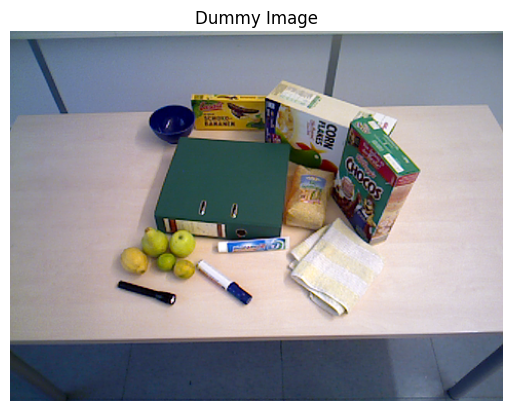

In [2]:
from matplotlib import pyplot as plt
import cv2
image_file = "images/clutter.png"
# load image as np array
dummy_image = cv2.imread(image_file)
def show_image(image, title="Image"):
	plt.imshow(image[:,:,::-1])  # Convert BGR to RGB for display
	plt.title(title)
	plt.axis('off')
	plt.show()
show_image(dummy_image, "Dummy Image")

Using default config file


~/anaconda3/envs/open_perception/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
~/Desktop/CMU/research/motorcortex/motor_cortex/motor_cortex/perception/open_vocab_perception_pipeline/src/open_perception/perception/detection_models.py:261: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = self.processor.post_process_grounded_object_detection(
~/anaconda3/envs/open_perception/lib/python3.11/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to 

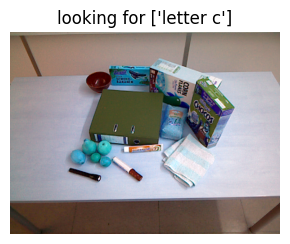

base_model_detections []


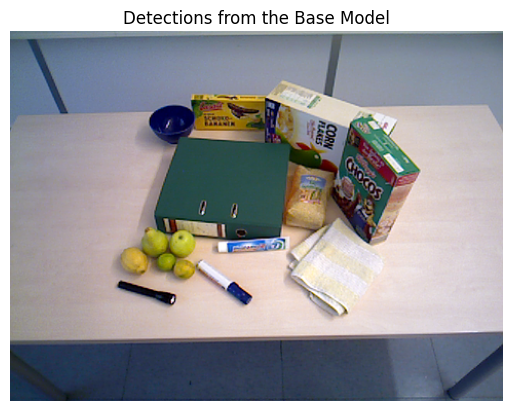

system: You are an AI assistant responsible for detecting objects and elements in an image. You will be provided with an image of the environment and a list of objects that the robot is trying to find (e.g. door, handle, key, etc). Your job is to properly use an external tool to locate the objects in the image and report back the findings. You can access the external tool by calling the function in_the_image(object_name: str, parent_object_name: str) -> bool.
e.g 1 human: "I am looking for the following item(s) in the image: : cube, cylinder, sphere" assistant tool calls: in_the_image('cube') -> True, in_the_image('cylinder') -> True, in_the_image('sphere') -> True assistant output: {'detections':{'cube': True, 'cylinder': True, 'sphere': True}, 'mapping':{}}
e.g 2 human: "I am looking for the following item(s) in the image: : person, chair" assistant tool calls: in_the_image('person') -> True, in_the_image('chair') -> False assistant tool calls: in_the_image('seat') -> True assistant 

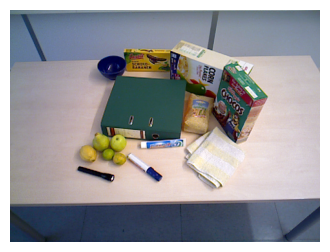

assistant: None
assistant: CALLING THE TOOL: in_the_image 	 with args: {"object_name":"letter c"}


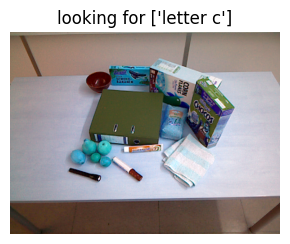

tool: Detection results:  letter c: False


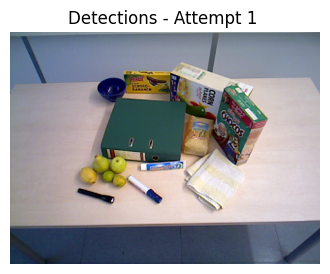

~/anaconda3/envs/open_perception/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `ChatCompletionMessageToolCall` - serialized value may not be as expected [input_value={'function': {'arguments'...5T', 'type': 'function'}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


assistant: None
assistant: CALLING THE TOOL: in_the_image 	 with args: {"object_name":"letter c","parent_object_name":"box"}


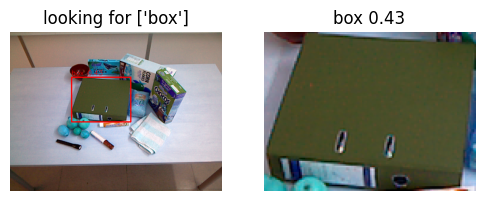

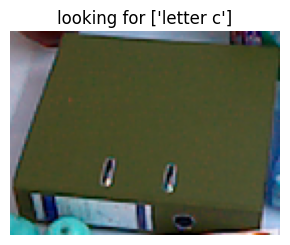

<Figure size 640x480 with 0 Axes>

tool: Detection results: box: True, box.letter c: False


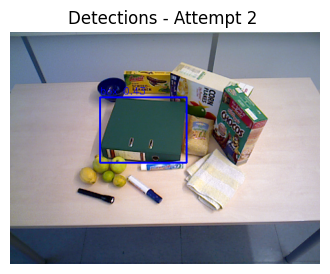

~/anaconda3/envs/open_perception/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `ChatCompletionMessageToolCall` - serialized value may not be as expected [input_value={'function': {'arguments'...0M', 'type': 'function'}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


assistant: None
assistant: CALLING THE TOOL: in_the_image 	 with args: {"object_name":"letter c","parent_object_name":"cereal"}


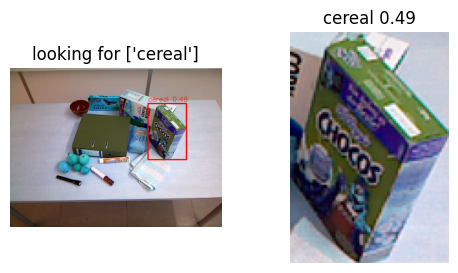

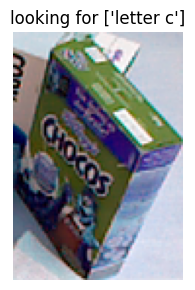

<Figure size 640x480 with 0 Axes>

tool: Detection results: cereal: True, cereal.letter c: False


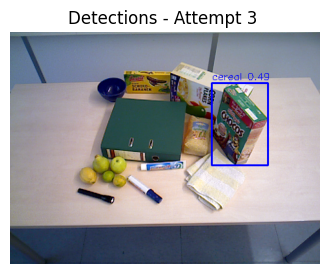

detections [{'bbox': array([[139, 102],
       [273, 203]], dtype=int32), 'class': 'box', 'prob': 0.4338477551937103, 'id': 0, 'is_parent': True}, {'bbox': array([[312,  80],
       [399, 207]], dtype=int32), 'class': 'cereal', 'prob': 0.4879411458969116, 'id': 0, 'is_parent': True}]


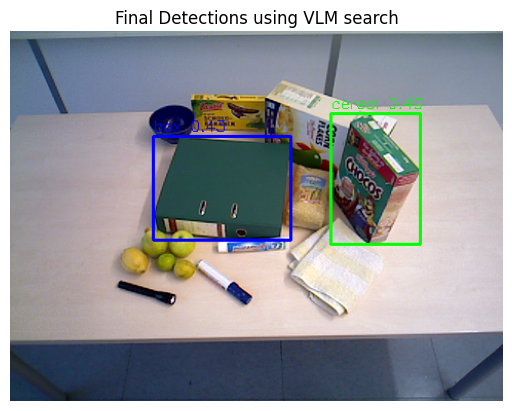

In [ ]:
%load_ext autoreload
%autoreload 2
config  = load_config()

vlm_search_config = config.pipeline.perception.vlm_search
model_config = {
    "box_threshold": 0.35,
    "text_threshold": 0.35,
    # "logging": {"level": "DEBUG"}
}

detection_model = GroundingDinoModelHF(model_config=model_config)
detection_model = MultigranularDetectionModel(model_config=model_config, detection_model=detection_model)
detection_model.debug=True

model = VLMDetectionWithSearch(
        vlm_search_config=vlm_search_config,
        model_config=model_config,
        detection_model=detection_model
    )
model.debug=True

model.load_model()
model.update_classes(["letter c"])

# Running the base model without deambiguation
base_model_detections = model.detection_model.run_inference(dummy_image)
print("base_model_detections", base_model_detections)

overlay = dummy_image.copy()
elements = detections_to_elements(base_model_detections)
overlay = draw_elements_detections(overlay, elements)
show_image(overlay, title="Detections from the Base Model")

# Running with deambiguation
detections = model.run_inference(dummy_image)
print("detections", detections)

overlay = dummy_image.copy()
elements = detections_to_elements(detections)
overlay = draw_elements_detections(overlay, elements)
show_image(overlay, title="Final Detections using VLM search")

